### Upload the dataset

In [51]:
from google.colab import files
uploaded = files.upload()

Saving synthetic_stock_dataset.csv to synthetic_stock_dataset.csv


### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

### Load the dataset

In [ ]:
file_path = 'synthetic_stock_dataset.csv'  # Change if using a different file
df = pd.read_csv(file_path)
print("Dataset loaded successfully!")
df.head()

Dataset loaded successfully!


Date        Open        High         Low       Close  Volume
0  2023-01-02  102.618870  103.920155  101.632235  100.496714  423694
1  2023-01-03  101.390915  102.365166  101.021243  100.358450  124826
2  2023-01-04   99.486768  100.671556   97.770053  101.006138  200734
3  2023-01-05  102.044934  103.772916  100.644314  102.529168  257702
4  2023-01-06  103.561926  103.658969  102.410650  102.295015  329834

### Data preprocessing
1. Initial checks and info

In [ ]:
# Display structure and missing data
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    252 non-null    object 
 1   Open    252 non-null    float64
 2   High    252 non-null    float64
 3   Low     252 non-null    float64
 4   Close   252 non-null    float64
 5   Volume  252 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 11.9+ KB


Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

### 2. Handle missing vaues

In [ ]:
# If any missing values exist, fill or drop them
if df.isnull().values.any():
    # Option 1: Drop missing rows
    df.dropna(inplace=True)
    # Option 2 (if preferred): Fill missing values with forward fill
    # df.fillna(method='ffill', inplace=True)

### 3. Remove duplicate values

In [ ]:
# Check for duplicates
duplicates = df.duplicated()
print("Duplicate rows:", duplicates.sum())

# Remove duplicates
df = df[~duplicates]

Duplicate rows: 0


### 4. Detect and treatoutliers

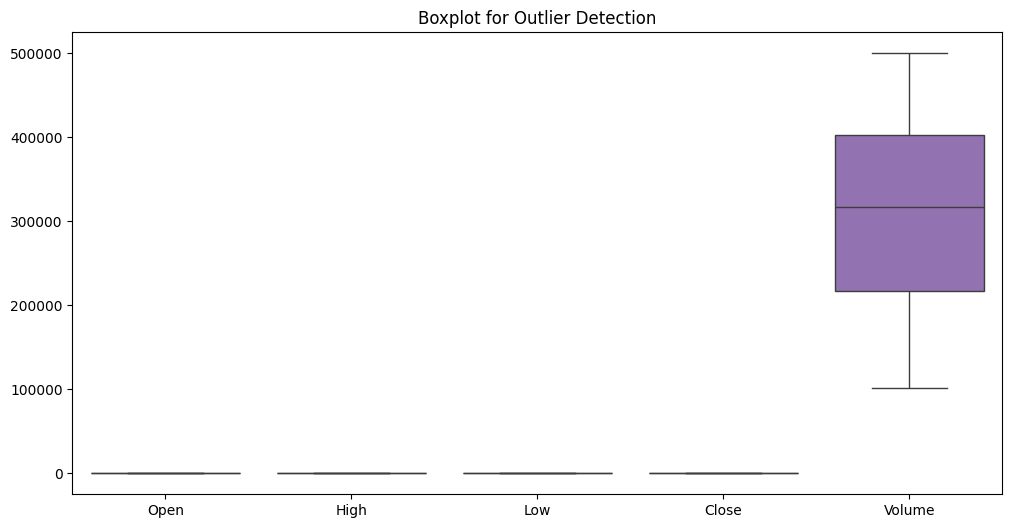

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualize outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Open', 'High', 'Low', 'Close', 'Volume']])
plt.title("Boxplot for Outlier Detection")
plt.show()

# Cap extreme outliers using IQR method (example on 'Volume')
Q1 = df['Volume'].quantile(0.25)
Q3 = df['Volume'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df['Volume'] = np.where(df['Volume'] > upper, upper,
                        np.where(df['Volume'] < lower, lower, df['Volume']))

### 5. Convert data types & Ensure consistency

In [ ]:
# Convert date to datetime if not already
df.index = pd.to_datetime(df.index)
# Check types
df.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

### 6. Encode categorial variables

In [ ]:
# Check for categorical columns
cat_cols = df.select_dtypes(include='object').columns
print("Categorical Columns:", cat_cols)

# One-hot encode (if applicable)
df = pd.get_dummies(df, columns=cat_cols)

Categorical Columns: Index(['Date'], dtype='object')


### 7. Normalize features

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

df_scaled = df.copy()
df_scaled[scaled_columns] = scaler.fit_transform(df[scaled_columns])

### Exploratory Data Analysis (EDA)
1. Univariate Analysis

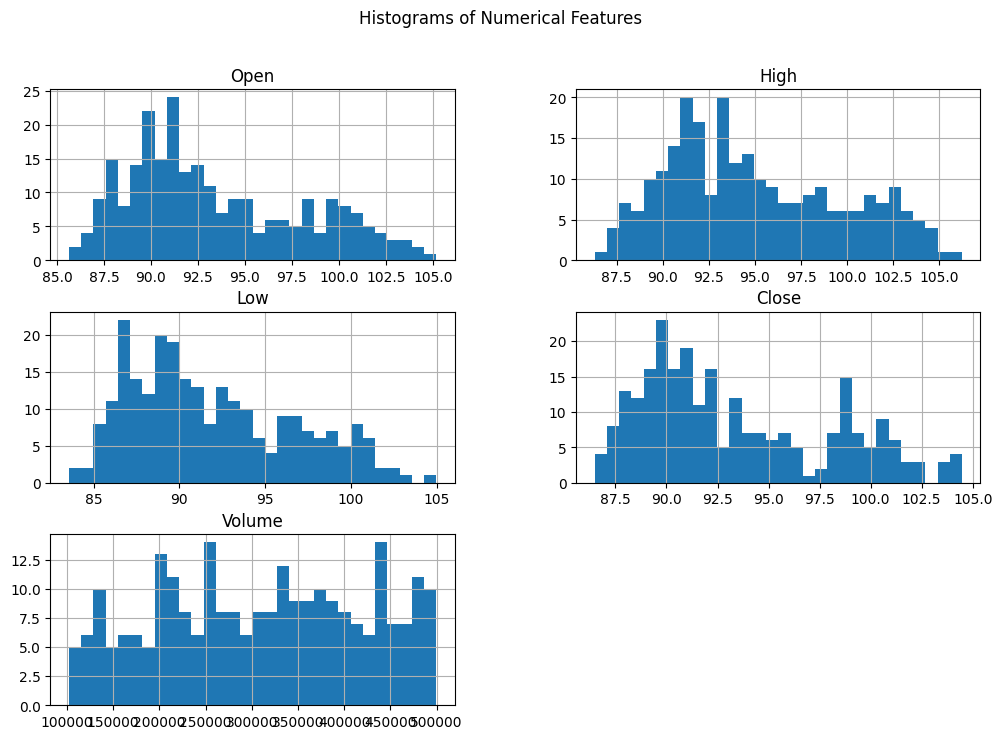

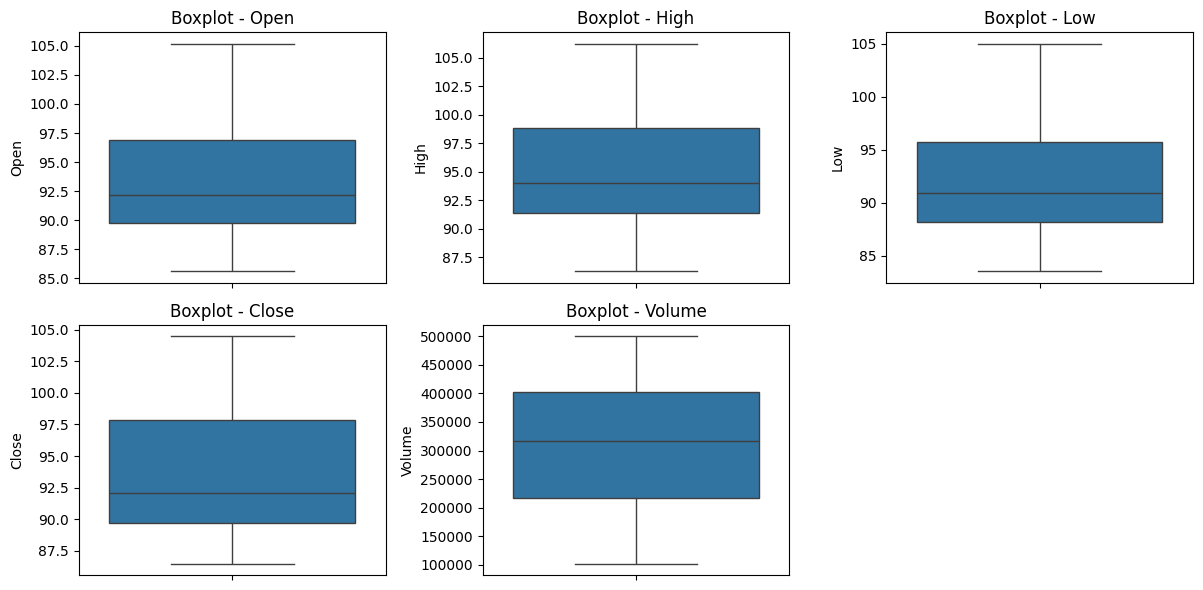

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# Histograms
df[numeric_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle("Histograms of Numerical Features")
plt.show()

# Boxplots
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot - {col}')
plt.tight_layout()
plt.show()

### Bivariate & Multivariate Analysis
1. Correlation Matrix


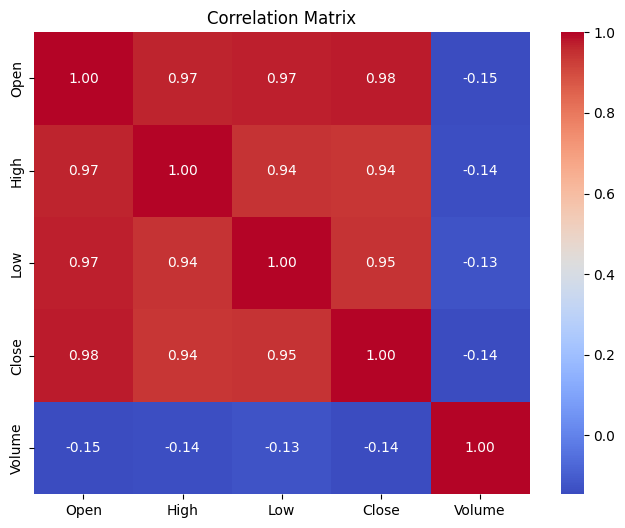

In [ ]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### 2. Pairplot

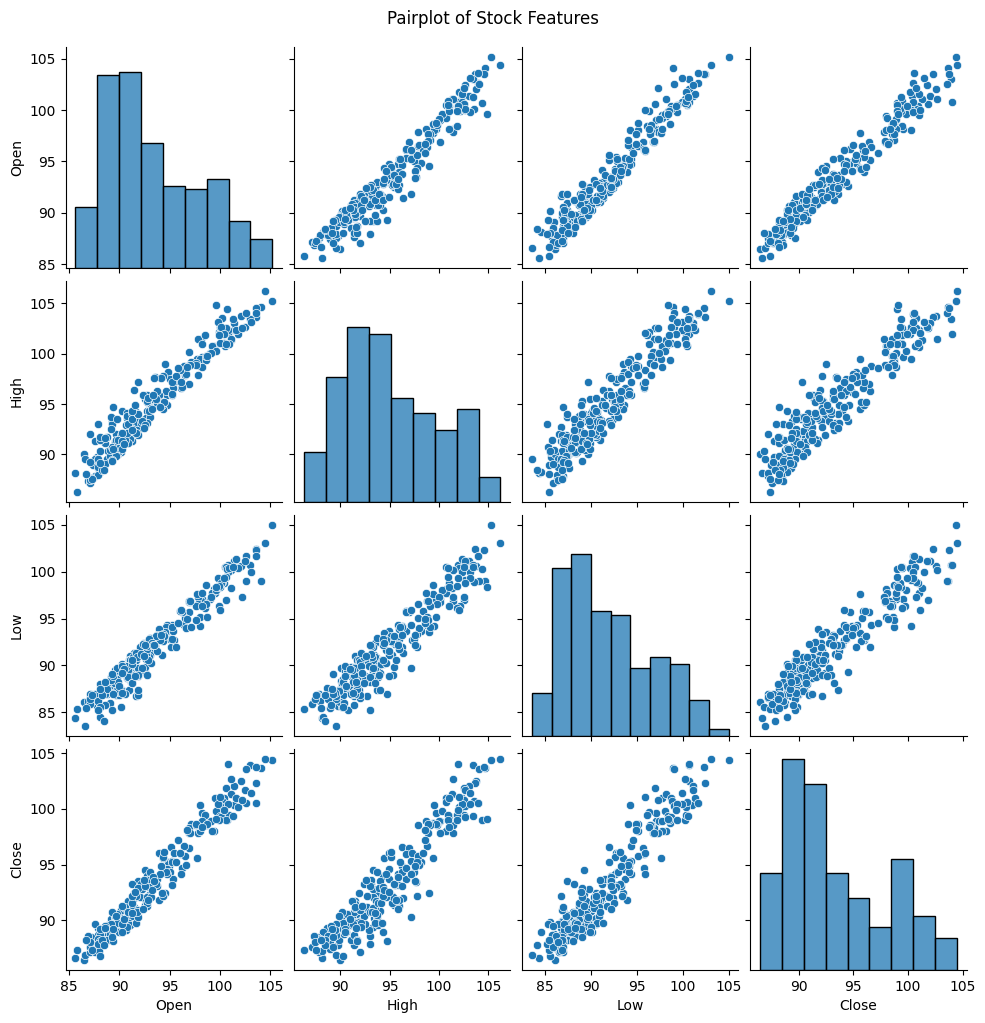

In [ ]:
# Pairplot for first 4 columns to visualize pairwise relationships
sns.pairplot(df[numeric_cols[:4]])
plt.suptitle("Pairplot of Stock Features", y=1.02)
plt.show()

### 3. Scatterplot: Features vs. Close Price

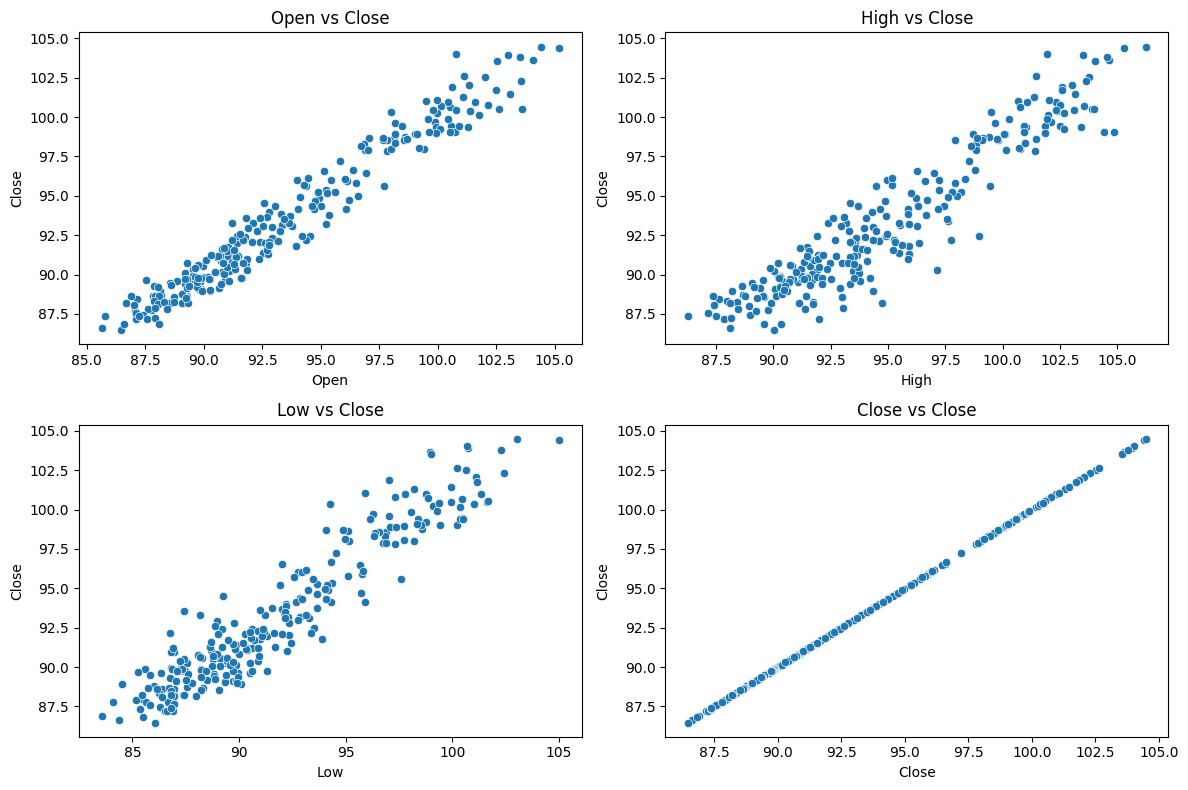

In [ ]:
# Scatterplots of all features vs. Close
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols[:-1], 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(data=df, x=col, y='Close')
    plt.title(f'{col} vs Close')
plt.tight_layout()
plt.show()

### Feature Engineering
1. Extract Temporal Features from Date

In [ ]:
df_fe = df.copy()

# Extract date-based features
df_fe['Day'] = df_fe.index.day
df_fe['Month'] = df_fe.index.month
df_fe['DayOfWeek'] = df_fe.index.dayofweek
df_fe['IsMonthStart'] = df_fe.index.is_month_start.astype(int)
df_fe['IsMonthEnd'] = df_fe.index.is_month_end.astype(int)

### 2. Rolling Statistics (Window Features)

In [ ]:
# 7-day and 21-day rolling statistics
df_fe['MA7'] = df_fe['Close'].rolling(window=7).mean()
df_fe['MA21'] = df_fe['Close'].rolling(window=21).mean()

# Rolling standard deviation
df_fe['STD21'] = df_fe['Close'].rolling(window=21).std()

### 3. Price-Based Ratios

In [ ]:
# Price momentum features
df_fe['Price_Range'] = df_fe['High'] - df_fe['Low']
df_fe['Daily_Change'] = df_fe['Close'] - df_fe['Open']
df_fe['Volatility_Ratio'] = df_fe['Price_Range'] / df_fe['Open']

### 4. Lag Features (for time-series prediction)

In [ ]:
# Lag features for Close price
df_fe['Lag1'] = df_fe['Close'].shift(1)
df_fe['Lag2'] = df_fe['Close'].shift(2)
df_fe['Lag3'] = df_fe['Close'].shift(3)

In [ ]:
df_fe.dropna(inplace=True)

### Model Building
1. Data Preparation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
# Define features and target for regression
features = ['Open', 'High', 'Low', 'Volume', 'Lag1', 'Lag2', 'Lag3', 'MA7', 'MA21']
target_reg = 'Close'

# Create classification target: 1 if next day close is higher, else 0
df_fe['Target_UpDown'] = (df_fe['Close'].shift(-1) > df_fe['Close']).astype(int)
target_cls = 'Target_UpDown'
# Drop last row with NaN from shift
df_fe = df_fe.dropna()

# Split data
X = df_fe[features]
y_reg = df_fe[target_reg]
y_cls = df_fe[target_cls]
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

### 2. Regression Models
Random Forest Regressor & Linear Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
# Train models
rf_reg = RandomForestRegressor(random_state=42)
lr_reg = LinearRegression()
rf_reg.fit(X_train_reg, y_train_reg)
lr_reg.fit(X_train_reg, y_train_reg)

# Predict
rf_pred = rf_reg.predict(X_test_reg)
lr_pred = lr_reg.predict(X_test_reg)

# Evaluate
def evaluate_regression(y_true, y_pred, model_name):
    print(f"\n📊 {model_name} Performance:")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    # Calculate RMSE without 'squared' argument
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("RMSE:", rmse)
    print("R²:", r2_score(y_true, y_pred))

evaluate_regression(y_test_reg, rf_pred, "Random Forest Regressor")
evaluate_regression(y_test_reg, lr_pred, "Linear Regression")


📊 Random Forest Regressor Performance:
MAE: 0.5861355825145496
RMSE: 0.775449500507759
R²: 0.9626874462537532

📊 Linear Regression Performance:
MAE: 0.5283079701840571
RMSE: 0.7403922364575145
R²: 0.9659849083593455


### 3. Classification Models
Logistic Regression & Random Forest Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# Train models
log_cls = LogisticRegression()
rf_cls = RandomForestClassifier(random_state=42)
log_cls.fit(X_train_cls, y_train_cls)
rf_cls.fit(X_train_cls, y_train_cls)

# Predict
log_pred = log_cls.predict(X_test_cls)
rf_pred_cls = rf_cls.predict(X_test_cls)
# Evaluate
def evaluate_classification(y_true, y_pred, model_name):
    print(f"\n📊 {model_name} Classification Report:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))

evaluate_classification(y_test_cls, log_pred, "Logistic Regression")
evaluate_classification(y_test_cls, rf_pred_cls, "Random Forest Classifier")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



📊 Logistic Regression Classification Report:
Accuracy: 0.5319148936170213
Precision: 0.5517241379310345
Recall: 0.64
F1 Score: 0.5925925925925926

📊 Random Forest Classifier Classification Report:
Accuracy: 0.48936170212765956
Precision: 0.5185185185185185
Recall: 0.56
F1 Score: 0.5384615384615384


### 4. Deep Learning Model: LSTM (for Regression)
 Step 1: Prepare Data for LSTM

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# Use Close-related features only for LSTM simplicity
lstm_features = ['Close']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_fe[lstm_features])

# Create sequences (last 60 days -> predict next day)
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)
X_lstm, y_lstm = create_sequences(scaled_data)

# Train-test split
split = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

### Step 2: Build & Train the LSTM Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
# Build model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train model
history = model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, validation_split=0.1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 377ms/step - loss: 0.0940 - val_loss: 0.2522
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - loss: 0.0232 - val_loss: 0.0578
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 0.0235 - val_loss: 0.0876
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0137 - val_loss: 0.1425
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 0.0146 - val_loss: 0.1608
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 0.0156 - val_loss: 0.1362
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0108 - val_loss: 0.1049
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0129 - val_loss: 0.0852
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0125 - val_loss: 0.0860
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0125 - val_loss: 0.0984
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0102 - val_loss: 0.1068
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0098 - val_lo

### Step 3: Evaluate the LSTM

In [ ]:
# Predict
predictions = model.predict(X_test_lstm)

# Inverse scale
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test_lstm)

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("LSTM Performance:")
print("MAE:", mean_absolute_error(actual_prices, predicted_prices))
print("RMSE:", np.sqrt(mean_squared_error(actual_prices, predicted_prices)))
print("R²:", r2_score(actual_prices, predicted_prices))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
LSTM Performance:
MAE: 1.9677061583404065
RMSE: 2.213854142067902
R²: -3.069447624111782


### Visualization of Results & Model Insights

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor

In [63]:
# Load dataset
df = pd.read_csv('synthetic_stock_dataset.csv')

# Feature and target columns
features = ['Open', 'High', 'Low', 'Volume']
target_reg = 'Close'

# Assuming 'Close' column exists for price prediction
# Create a new column 'Price_Up' based on whether 'Close' increased compared to previous day
df['Price_Up'] = (df['Close'] > df['Close'].shift(1)).astype(int)
target_clf = 'Price_Up'

In [64]:
# Split data for regression
X = df[features]
y_reg = df[target_reg]
X_train, X_test, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Split data for classification
y_clf = df[target_clf]
_, _, y_clf_train, y_clf_test = train_test_split(X, y_clf, test_size=0.2, random_state=42)

In [65]:
# Train regression model
xgb_reg = XGBRegressor(n_estimators=100, random_state=42)
xgb_reg.fit(X_train, y_reg_train)
y_reg_pred = xgb_reg.predict(X_test)
# Train classification model (faster model)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_clf_train)
y_clf_pred = rf_clf.predict(X_test)
y_clf_prob = rf_clf.predict_proba(X_test)[:, 1]

In [66]:
# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
mae = mean_absolute_error(y_reg_test, y_reg_pred)
conf_matrix = confusion_matrix(y_clf_test, y_clf_pred)
fpr, tpr, _ = roc_curve(y_clf_test, y_clf_prob)
roc_auc = auc(fpr, tpr)
feat_importance_rf = rf_clf.feature_importances_

In [67]:
# Sample residuals for plotting
sample_size = min(200, len(y_reg_test))
sampled_indices = np.random.choice(len(y_reg_test), size=sample_size, replace=False)
residuals_sample = y_reg_test.iloc[sampled_indices] - y_reg_pred[sampled_indices]
y_reg_pred_sample = y_reg_pred[sampled_indices]

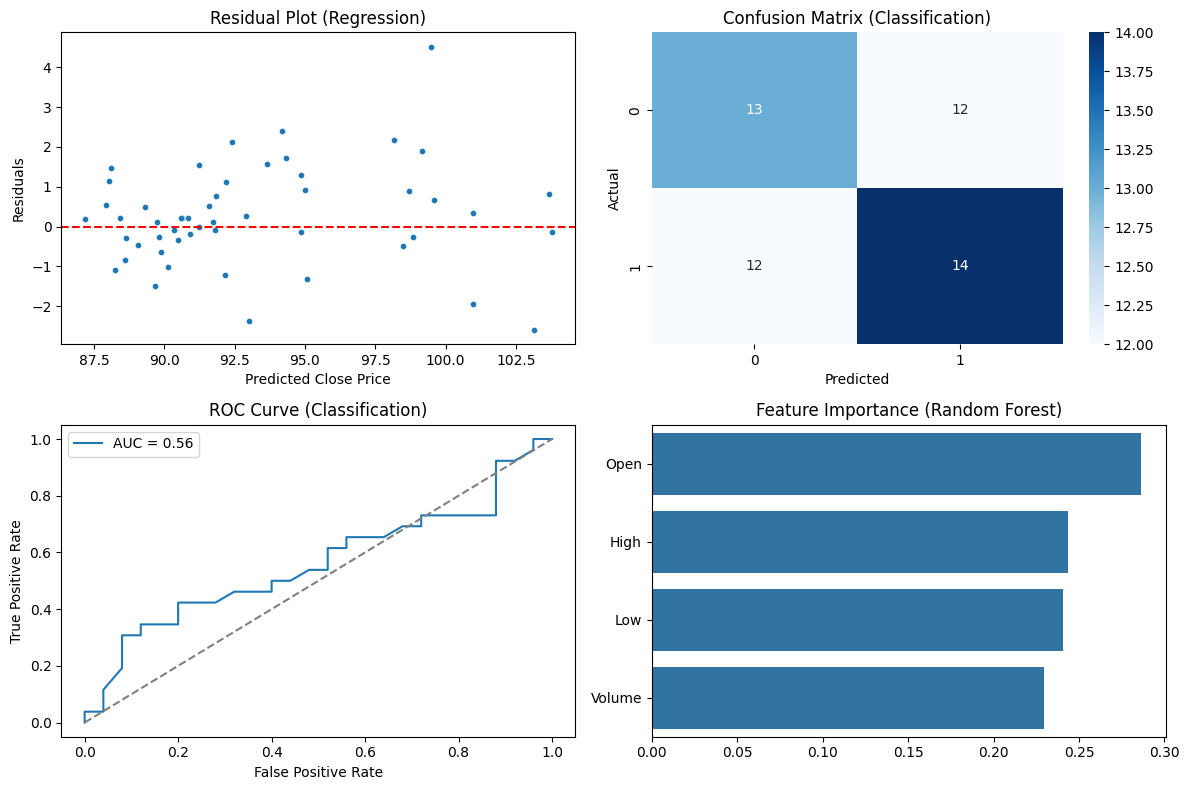

RMSE (Regression): 1.28
MAE (Regression): 0.94
AUC (Classification): 0.56


In [68]:
# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Residual Plot (Regression)
sns.scatterplot(x=y_reg_pred_sample, y=residuals_sample, ax=axs[0, 0], s=20)
axs[0, 0].axhline(0, color='red', linestyle='--')
axs[0, 0].set_title('Residual Plot (Regression)')
axs[0, 0].set_xlabel('Predicted Close Price')
axs[0, 0].set_ylabel('Residuals')

# Confusion Matrix (Classification)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[0, 1])
axs[0, 1].set_title('Confusion Matrix (Classification)')
axs[0, 1].set_xlabel('Predicted')
axs[0, 1].set_ylabel('Actual')

# ROC Curve
axs[1, 0].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
axs[1, 0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[1, 0].set_title('ROC Curve (Classification)')
axs[1, 0].set_xlabel('False Positive Rate')
axs[1, 0].set_ylabel('True Positive Rate')
axs[1, 0].legend()

# Feature Importance
sns.barplot(x=feat_importance_rf, y=features, ax=axs[1, 1])
axs[1, 1].set_title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

# Print performance metrics
print(f'RMSE (Regression): {rmse:.2f}')
print(f'MAE (Regression): {mae:.2f}')
print(f'AUC (Classification): {roc_auc:.2f}')